# Evaluate Mispredictions

This notebook evaluates parses the results of the simulation and plots the number of mispredictions for each configuration. It also serves to reproduce the main results (Figure 9) in the paper.


In [6]:

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.ticker as mticker



from matplotlib import rcParams

# 设置字体为 SimHei 或其他支持中文的字体
rcParams['font.sans-serif'] = ['SimHei']  # Windows 推荐 SimHei
rcParams['axes.unicode_minus'] = False   # 解决负号 '-' 显示为方块的问题

## Loading and parsing the data

In [21]:

dict = {}


# 定义模型列表，其中包含模型配置和名称
models = [

    ("tage64kscl-ae", "64K TSL"),
    ("tage512kscl-ae", "512K TSL"),
    ("llbp-timing-ae", "LLBP"),
    ("llbp-ae", "LLBP-0Lat"),

]
# 定义基准测试列表，每个基准测试包含配置名称和显示名称
bms = [
    ('nodeapp-nodeapp', 'NodeApp'),
    ('mwnginxfpm-wiki', 'PHPWiki'),

    ('benchbase-tpcc', 'TPCC'),
    ('benchbase-twitter', 'Twitter'),
    ('benchbase-wikipedia', 'Wikipedia'),
    ('dacapo-kafka', 'Kafka'),
    ('dacapo-spring', 'Spring'),
    ('dacapo-tomcat', 'Tomcat'),
    ('renaissance-finagle-chirper', 'Chirper'),
    ('renaissance-finagle-http', 'HTTP'),

    ('charlie.1006518', 'Charlie'),
    ('delta.507252', 'Delta'),
    ('merced.467915', 'Merced'),
    ('whiskey.426708', 'Whiskey'),
]



# 创建一个空的DataFrame用于存储所有数据
dfall = pd.DataFrame()

# data = {}
# 遍历每个模型配置
for cfg, n in models:

    dftmp = pd.DataFrame() # 创建一个临时DataFrame用于当前模型的数据存储
    for bm,name in bms:

        with open(f"../results/{bm}/{cfg}.txt") as f: # 打开基准测试结果文件并解析相关数据

            dict = { "Model" : n, "Benchmark" : name} # 创建一个字典存储模型和基准测试名称

            # 遍历文件的每一行并提取相关指标
            for line in f:
                if "ROI INSTRUCTIONS" in line: # 提取指令数量
                    dict["Ninst"] = int(line.split()[-1])
                if "ROI MISPREDICTIONS" in line: # 提取错误预测数量
                    dict["Misp"] = int(line.split()[-1])
                if "ROI MPKI" in line: # 提取每千条指令的错误预测率
                    dict["MPKI"] = float(line.split()[-1])

             # 将解析的数据添加到临时DataFrame
            dftmp = pd.concat([dftmp, pd.DataFrame(dict, index=[0])])

    # 打印当前模型的记录条目数量    
    print(n, len(dftmp))
    # 计算当前模型的平均值并添加到数据集中
    dm = {"Model": n, "Benchmark": "Mean" }
    for metric in dftmp.columns[2:]: # 遍历指标列
        dm[metric] = dftmp[metric].mean()

    # 合并数据到总DataFrame
    dfall = pd.concat([dfall, dftmp, pd.DataFrame([dm])])


# 计算MPKI的减少率
# 初始化MPKI Reduction列为0.0
## Calculate MPKI reduction
dfall["MPKI Reduction"] = 0.0
ref = "64K TSL" # 参考模型名称

# 遍历所有基准测试
for bm in dfall["Benchmark"].unique():

    # 指标变量
    # m = "misp"
    m = "MPKI"
    # m = "time"

    # 获取参考模型的MPKI值
    tage64ksc_mpki = dfall.loc[(dfall["Benchmark"] == bm) & (dfall["Model"] == ref), m].values[0]

    # 计算MPKI减少率
    dfall.loc[dfall["Benchmark"] == bm, "MPKI Reduction"] = (tage64ksc_mpki - dfall.loc[dfall["Benchmark"] == bm, m]) / tage64ksc_mpki


64K TSL 14
512K TSL 14
LLBP 14
LLBP-0Lat 14


## Absolute MPKI

64K TSL
LLBP
LLBP-0Lat
512K TSL


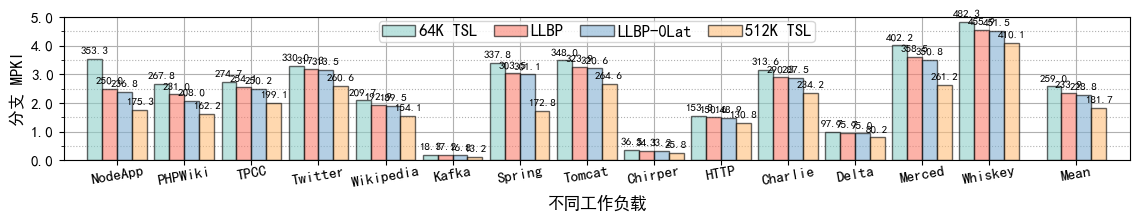

In [19]:


width = 0.7       # the width of the bars: can also be len(x) sequence


cw=11.5
fs=12

fig, axs = plt.subplots(1, 1, figsize=(cw,cw*0.2), sharex=True, sharey=False)

_bms = [b[1] for b in bms] + ["Mean"]

x = np.array([x_+0.3 if l in ["GMean", "Mean"] else x_ for x_,l in enumerate(_bms)])

colors = {
    '64K TSL': '#8ECFC9',  
    "512K TSL": '#FFBE7A',
    "LLBP": '#FA7F6F',  
    "LLBP-0Lat": '#82B0D2',  
}


plot_models = [

    "64K TSL",
    "LLBP",
    "LLBP-0Lat",
    "512K TSL",
]


nbars = len(plot_models)
bar_width = float(1) / float(nbars+0.5)
init_offset = float(-nbars*bar_width) / 2
get_offset = lambda n : init_offset + n * bar_width


ax = axs

m = "MPKI"

for i, model in enumerate(plot_models):

    # if i == 0:
    #     continue


    print(model)
    dftmp = dfall[dfall["Model"] == model].set_index("Benchmark")

    y = dftmp.loc[_bms, m].values



    bars = ax.bar(x+get_offset(i), y, width=bar_width, bottom=0, #hatch=hatches[j],
            color=colors[model], label=model,
            align='edge', edgecolor='k',zorder=2.3,alpha=0.6)
    

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height*100:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)





## Grid
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.grid(True, which='both')
ax.grid(True, which='minor', linestyle=':')

ax.set_ylabel("分支 MPKI", fontsize=fs)
ax.set_xlabel("不同工作负载", fontsize=fs)

_y = ax.get_yticks()
ax.set_yticks(_y)
ax.set_yticklabels([f"{y:.1f}" for y in _y], fontsize=fs-1)

# for container in ax.containers:
#     ax.bar_label(container, fontsize=7, fmt="%.2f", rotation=90)


## Format x-axis
ax.set_xticks(x)
ax.set_xticklabels(_bms, rotation=10, horizontalalignment="center", fontsize=fs-1)
ax.tick_params(axis='x', which='major', pad=0)

ax.set_ylim(bottom=-0.0, top=5)



handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, labels, bbox_to_anchor=(0.5,1.03), loc="upper center", fontsize=fs, ncol=8,
            labelspacing=0.05, columnspacing=1.,handletextpad=0.2,borderpad=0.2,frameon=True)

# ax.legend(loc="best", fontsize="9", )
ax.set_xlim(left=x[0]-0.8, right=x[-1]+0.8)





fig.tight_layout()


fig.savefig("mpki.pdf",dpi=300,format="pdf",bbox_inches='tight', pad_inches=0, facecolor="w")
# fig.savefig("performance_study.png",dpi=300,bbox_inches='tight', pad_inches=0, facecolor="w")

## MPKI Reduction

LLBP
LLBP-0Lat
512K TSL


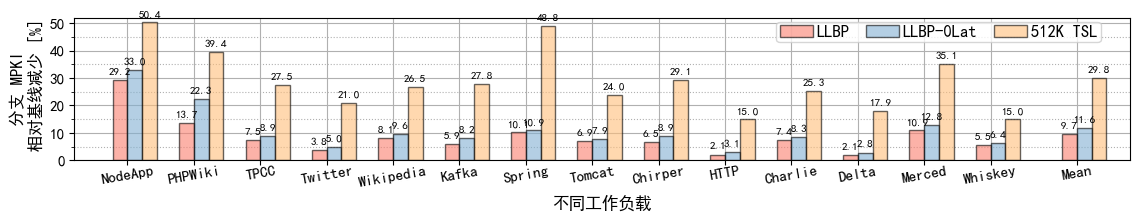

In [18]:


width = 0.7
cw=11.5
fs=12

fig, axs = plt.subplots(1, 1, figsize=(cw,cw*0.2), sharex=True, sharey=False)

_bms = [b[1] for b in bms] + ["Mean"]

x = np.array([x_+0.3 if l in ["GMean", "Mean"] else x_ for x_,l in enumerate(_bms)])

colors = {
    '64K TSL': '#8ECFC9',  
    "512K TSL": '#FFBE7A',
    "LLBP": '#FA7F6F',  
    "LLBP-0Lat": '#82B0D2',  
}


plot_models = [
    "64K TSL",
    "LLBP",
    "LLBP-0Lat",
    "512K TSL",
]


nbars = len(plot_models)
bar_width = float(1) / float(nbars+0.5)
init_offset = float(-nbars*bar_width) / 2
get_offset = lambda n : init_offset + n * bar_width


ax = axs

m = "MPKI Reduction"

for i, model in enumerate(plot_models):

    if i == 0:
        continue

    print(model)
    dftmp = dfall[dfall["Model"] == model].set_index("Benchmark")

    y = dftmp.loc[_bms, m].values

    bars = ax.bar(x+get_offset(i), y, width=bar_width, bottom=0, #hatch=hatches[j],
            color=colors[model], label=model,
            align='edge', edgecolor='k',zorder=2.3,alpha=0.6)
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height*100:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)
    
    



## Grid
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.grid(True, which='both')
ax.grid(True, which='minor', linestyle=':')

ax.set_ylabel("分支 MPKI\n 相对基线减少 [%]", fontsize=fs)


ax.set_xlabel("不同工作负载", fontsize=fs)

_y = ax.get_yticks()
ax.set_yticks(_y)
ax.set_yticklabels([f"{y*100:.0f}" for y in _y], fontsize=fs-1)

# for container in ax.containers:
#     ax.bar_label(container, fontsize=7, fmt="%.3f", rotation=90)

## Format x-axis
ax.set_xticks(x)
ax.set_xticklabels(_bms, rotation=10, horizontalalignment="center", fontsize=fs-1)
ax.tick_params(axis='x', which='major', pad=0)

ax.set_ylim(bottom=-0.0, top=0.52)


handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, labels, bbox_to_anchor=(0.98,1.03), loc="upper right", fontsize=fs, ncol=8,
            labelspacing=0.05, columnspacing=1.,handletextpad=0.2,borderpad=0.2,frameon=True)

ax.set_xlim(left=x[0]-0.8, right=x[-1]+0.8)


fig.tight_layout()


fig.savefig("mpki_reduction.pdf",dpi=300,format="pdf",bbox_inches='tight', pad_inches=0, facecolor="w")